# Calling `R` from `Python` with `rpy2`

* Why bother? 
    - Domain-specific `R` and general purpose `Python`
    - "Oject-orientied side `R` feels like an afterthought" (from *Evaluating the Design of R*)
    - Naming convention chaos in `R`
    - Some implementations in `R` is very inefficent (try compare `xlsReadWrite::read.xls` and `pandas.read_excel`)
    - Package management in `R` (`base::rep()` syntax v.s. `numpy.rep()` syntax)
    - *But most the cutting edge statistics and machine learning methods appears in `R` first*
<br><br><br><br><br>   
*                                *Lei Zhu*, lei.ctzhu@gmail.com, 04/12/2016

#  Installation

* `R` already installed

* Mac and Linux (`gcc` or `clang` compiler might be needed): 
```
    pip install rpy2
    conda install rpy2 #if using Anaconda Python distribution.
```

* Windows:

    [Laboratory for Fluorescence Dynamics, University of California, Irvine](http://www.lfd.uci.edu/~gohlke/pythonlibs/)
    - Get the binary matching your environment, such as `rpy2-2.7.8-cp27-none-win_amd64.whl`
    - `pip install [path_to_your_binary]rpy2-2.7.8-cp27-none-win_amd64.whl`
    
    
* Might need to setup some evironment variables such as (`R_HOME`, `R_USER`, etc) depending on your machine

    - Can sometimes be tricky, ask me, or stackoverflow.com, or me_on_stackoverflow

# `Hello World` example, running `R` scripts with `.reval()` method:

In [1]:
from rpy2 import robjects
robjects.reval('a <- c(0,1,2,3)')
robjects.reval('print(a)')
robjects.reval("s <- 'Hello World!'")
robjects.reval("print(s)")

<rpy2.rinterface.StrSexpVector - Python:0x00000000091B7738 / R:0x000000000AF70EA0>

### *The output is in your console or terminal window*

# Access `R` objects from `Python`

In [2]:
robjects.globalenv.get('a') #

<FloatVector - Python:0x000000000931FE08 / R:0x000000000A453ED0>
[0.000000, 1.000000, 2.000000, 3.000000]

In [3]:
robjects.globalenv.get('b')

LookupError: 'b' not found

In [4]:
robjects.r.a

<FloatVector - Python:0x000000000C7E3848 / R:0x000000000A453ED0>
[0.000000, 1.000000, 2.000000, 3.000000]

# `Python` and `R` are accessing the same memory object (!)

In [5]:
(robjects.r.a)[2] = 5.
robjects.r.a

#print robjects.reval('print(a)')
#[1] 0 1 5 3

<FloatVector - Python:0x000000000C7E3CC8 / R:0x000000000A453ED0>
[0.000000, 1.000000, 5.000000, 3.000000]

### Common problem: wrong dtype

* in `R` `vector` is similar to a `numpy.array`, it is a contiguous memory block, holding data of the same type

In [6]:
(robjects.r.a)[2] = 5 #an int

ValueError: The new value cannot be of 'typeof' other than 14 ('13' given)

# Now you can use the `%%r` cellmagic in `Jupyter`

In [7]:
%load_ext rpy2.ipython
# run R? to get the guide for R cell magic

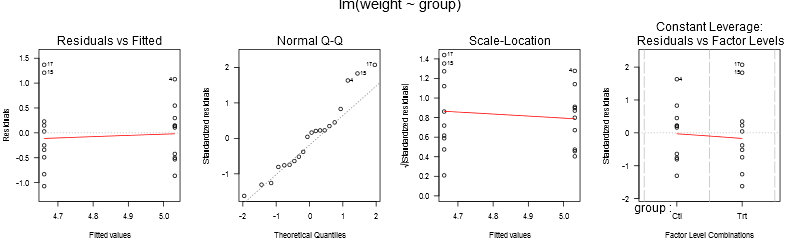

In [8]:
%%R -w 800 -h 250
## From R document of lm()
## Annette Dobson (1990) "An Introduction to Generalized Linear Models".
## Page 9: Plant Weight Data.
ctl <- c(4.17,5.58,5.18,6.11,4.50,4.61,5.17,4.53,5.33,5.14)
trt <- c(4.81,4.17,4.41,3.59,5.87,3.83,6.03,4.89,4.32,4.69)
group <- gl(2, 10, 20, labels = c("Ctl","Trt"))
weight <- c(ctl, trt)
lm.D9 <- lm(weight ~ group)
lm.D90 <- lm(weight ~ group - 1) # omitting intercept

anova(lm.D9)
summary(lm.D90)

opar <- par(mfrow = c(1,4), oma = c(0, 0, 1.1, 0))
plot(lm.D9, las = 1)      # Residuals, Fitted, ...
par(opar)

# Hey, my model summaries are missing
- Only the last output is rendered, which is the plot

In [9]:
robjects.reval('A1 <- anova(lm.D9)')
robjects.reval('S1 <- summary(lm.D90)')
print robjects.r.S1


Call:
lm(formula = weight ~ group - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4938  0.0685  0.2462  1.3690 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
groupCtl   5.0320     0.2202   22.85 9.55e-15 ***
groupTrt   4.6610     0.2202   21.16 3.62e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6964 on 18 degrees of freedom
Multiple R-squared:  0.9818,	Adjusted R-squared:  0.9798 
F-statistic: 485.1 on 2 and 18 DF,  p-value: < 2.2e-16




# Data Frames, from `R` to `Python`

In [10]:
import pandas as pd
import numpy as np
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Use `ri2py_dataframe()`: convert `R` datafame to `python` `pandas.DataFrame`

Model ANOVA table

In [11]:
pandas2ri.ri2py_dataframe(robjects.r.A1)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
group,1,0.688205,0.688205,1.419101,0.249023
Residuals,18,8.729250,0.484958,NaN,NaN


# Access members of `R` object using `rx` method

- You might know that `summary` object of `R` linear model `lm` is not a DataFrame

- But some of its members are `data.frames` or `Matrix`, such as `Coefficients`

In [12]:
pandas2ri.ri2py_dataframe(robjects.r.S1)

TypeError: 'Formula' object is not iterable

# Access and convert the regression coefficient matrix to `pandas.DataFrame`

In [13]:
print robjects.r.S1.rx2('coefficients')

         Estimate Std. Error  t value     Pr(>|t|)

groupCtl    5.032  0.2202177 22.85012 9.547128e-15

groupTrt    4.661  0.2202177 21.16542 3.615345e-14



In [14]:
# The preferred way in newer versions will ignore the column and row lables
pandas2ri.ri2py_dataframe(robjects.r.S1.rx2('coefficients'))

,0,1,2,3
0,5.032,0.220218,22.850117,9.547128e-15
1,4.661,0.220218,21.165420,3.615345e-14


In [16]:
# The old version actually does a better job
import pandas.rpy.common as com
com.convert_robj(robjects.r.S1.rx2('coefficients'))

,Estimate,Std. Error,t value,Pr(>|t|)
groupCtl,5.032,0.220218,22.850117,9.547128e-15
groupTrt,4.661,0.220218,21.165420,3.615345e-14


In [17]:
# A possible fix
robjects.reval('v1 <- as.data.frame(S1$coefficients)')
pandas2ri.ri2py_dataframe(robjects.r.v1)

,Estimate,Std. Error,t value,Pr(>|t|)
groupCtl,5.032,0.220218,22.850117,9.547128e-15
groupTrt,4.661,0.220218,21.165420,3.615345e-14


# Making `Python` objects visible to `R` objects with `robjects.r.assign`

- Make a `numpy.NDarray` visible to `R`

In [18]:
arr1 = np.array([0,1,2,3,4])
robjects.r.assign('arr1', arr1)
robjects.r.arr1

<Array - Python:0x000000000CC22708 / R:0x000000000A4E2860>
[       0,        1,        2,        3,        4]

In [19]:
iris = pd.read_csv('https://raw.github.com/pydata/pandas/master/pandas/tests/data/iris.csv')
robjects.r.assign('iris', iris)
#now you can access it, for example, from %%R cell magic
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Classial decision tree example using RA Fisher iris dataset

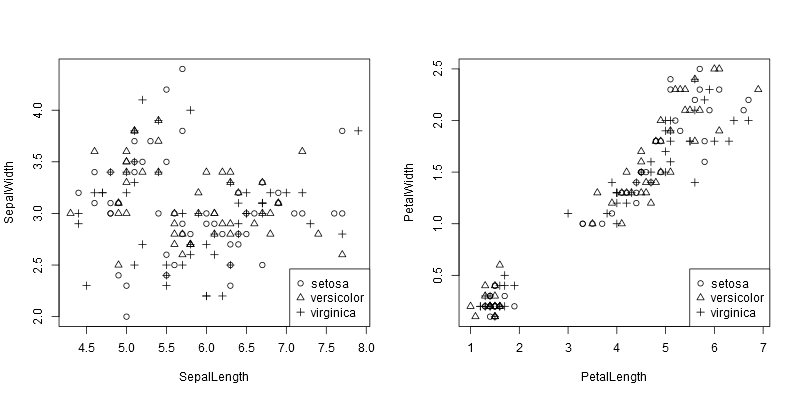

In [20]:
%%R -w 800 -h 400
par(mfrow = c(1,2))
with(iris, plot(SepalLength, SepalWidth, pch=c(1,2,3)))
with(iris, plot(PetalLength, PetalWidth, pch=c(1,2,3)))
legend('bottomright', c('setosa', 'versicolor', 'virginica'), pch=c(1,2,3))

# Decision Tree using package `rpart`

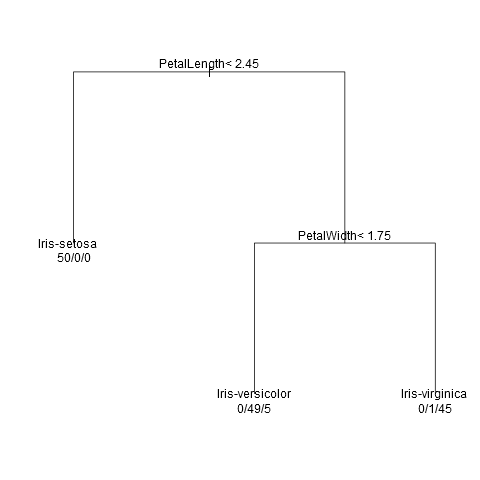

In [21]:
%%R
#install.packages("rpart")
library(rpart)
tree1 <- rpart(Name ~ ., method = "class", data = iris)
par(xpd=NA)
plot(tree1)
text(tree1, use.n=T)

# Limitation of `rpy2` (and some notes on implementation)

- The `r` object in `rpy2.robjects` represents a running embedded `R` process
- Therefore you might run into limitation imposed by limitations of embeded `R`
    - data too large to run in embeded `R`, but runs just fine otherwise
    - jobs takes slightly longer to run in `rpy2` than `R`
- Alternative: [`PypeR`](https://pypi.python.org/pypi/PypeR/1.1.0)
    - Use pipe to send scripts directly to `R`.
    - Far less popular, very little develop since 2010
    
<br><br>
# Questions?

In [ ]:
!jupyter nbconvert --to slides Rpy2_intro.ipynb --reveal-prefix "https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.1.0"